In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shapefile as shp
import re
from OSGridConverter import grid2latlong
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from pyproj import Transformer

In [3]:
LCMS_df = pd.read_table('LCMS Target Screening detections raw data 2023-08-02.tsv')
GCMS_df = pd.read_table('GCMS Target Screening detections raw data 2023-08-02.tsv')
CAS_codes = pd.read_csv('archive/PMNACC_062017.csv')
CAS_codes_two = pd.read_csv('archive/TSCAINV_062017.csv')

responses_df = pd.read_csv('ecotox_ascii_09_14_2023/dose_responses.txt', sep='|')
tests_df = pd.read_csv('ecotox_ascii_09_14_2023/tests.txt', sep='|',encoding_errors='ignore')
effect_codes_df = pd.read_csv('ecotox_ascii_09_14_2023/validation/effect_codes.txt', sep='|', encoding_errors='ignore')
chemicals_df = pd.read_csv('ecotox_ascii_09_14_2023/validation/chemicals.txt', sep='|', encoding_errors='ignore')
doses_df = pd.read_csv('ecotox_ascii_09_14_2023/doses.txt', sep='|', encoding_errors='ignore')

fish_toxicity = pd.read_csv('fish_df.txt', sep='|')

print(LCMS_df['year'].unique())
#print(GCMS_df['year'].unique())

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_77029/2677225828.py:7: DtypeWarning: Columns (4,6,8,9,10,11,13,15,20,22,23,25,27,30,32,34,37,38,39,40,41,42,45,48,49,50,51,53,56,57,58,59,61,64,66,68,70,72,74,76,78,79,81,83,85,86,87,89,91,94,96,100,102,104,106,107,109,111,114,116,119,126) have mixed types. Specify dtype option on import or set low_memory=False.
  tests_df = pd.read_csv('ecotox_ascii_09_14_2023/tests.txt', sep='|',encoding_errors='ignore')
/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_77029/2677225828.py:10: DtypeWarning: Columns (6,8,10,13,15,17,21,22,23,24,25,26,27,28,29,30,32,33,34,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  doses_df = pd.read_csv('ecotox_ascii_09_14_2023/doses.txt', sep='|', encoding_errors='ignore')


[2018 2021 2019 2022 2020 2023 2016 2017 2014 2015 2013 2011]


In [4]:
LCMS_GCMS_df = LCMS_df.append(GCMS_df)
LCMS_GCMS_df.to_csv('LCMS_GCMS.csv')
#LCMS_GCMS_df.head()
#CAS_codes.head()
CAS_codes_two.head()
#print(CAS_codes_two['casregno'].unique())
#CAS_codes_two.loc[CAS_codes_two['casregno']==86306]
fish_toxicity.head()

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_77029/2024443562.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LCMS_GCMS_df = LCMS_df.append(GCMS_df)


,CAS Number,Chemical Name,Chemical Grade,Chemical Analysis,Chemical Purity Mean Op,Chemical Purity Mean(%),Chemical Purity Min Op,Chemical Purity Min(%),Chemical Purity Max Op,Chemical Purity Max(%),...,BCF 3 Min,BCF 3 Max Op,BCF 3 Max,BCF 3 Unit,Author,Reference Number,Title,Source,Publication Year,Unnamed: 86
0,50293,"1,1'-(2,2,2-Trichloroethylidene)bis[4-chlorobe...",Not reported,Not reported,NaN,99.3,NaN,NR,NaN,NR,...,NaN,NaN,NaN,NaN,"Hansen,D.J.",14574,Unpublished Data on the Consent Decree Chemicals,"February 22 Memo to W.A.Brungs, U.S.EPA, Gulf ...",1980,NaN
1,50293,"1,1'-(2,2,2-Trichloroethylidene)bis[4-chlorobe...","Technical grade, technical product, technical ...",Unmeasured,NaN,NR,NaN,NR,NaN,NR,...,NaN,NaN,NaN,NaN,"Hansen,D.J.",14574,Unpublished Data on the Consent Decree Chemicals,"February 22 Memo to W.A.Brungs, U.S.EPA, Gulf ...",1980,NaN
2,50293,"1,1'-(2,2,2-Trichloroethylidene)bis[4-chlorobe...",Not reported,Not reported,NaN,99.3,NaN,NR,NaN,NR,...,NaN,NaN,NaN,NaN,"Hansen,D.J.",14574,Unpublished Data on the Consent Decree Chemicals,"February 22 Memo to W.A.Brungs, U.S.EPA, Gulf ...",1980,NaN
3,50293,"1,1'-(2,2,2-Trichloroethylidene)bis[4-chlorobe...",Not reported,Unmeasured,NaN,NR,NaN,NR,NaN,NR,...,NaN,NaN,NaN,NaN,"Butler,P.A.",807,Commercial Fishery Investigations,"In: Circular 226, Effects of Pesticides on Fis...",1965,NaN
4,50293,"1,1'-(2,2,2-Trichloroethylidene)bis[4-chlorobe...","Technical grade, technical product, technical ...",Unmeasured,NaN,NR,NaN,NR,NaN,NR,...,NaN,NaN,NaN,NaN,"Hansen,D.J.",14574,Unpublished Data on the Consent Decree Chemicals,"February 22 Memo to W.A.Brungs, U.S.EPA, Gulf ...",1980,NaN


In [5]:
unique_uses = LCMS_GCMS_df["USE"].tolist()
#regex
#chemical patterns
simplified_usage_list = []
patternP='DEET|Pesticide|Intermediate; Pesticides|Insecticide|2,4-D preparation|Biocide|Plant'
patternE='Veterinary|Equine|Eterinary drug'
patternd='Quinoline|Diclofenac|Scabicidal|Mucoactive|Lipid|Pharmaceutical|Prohoromome|Anticonvulsant|Antihistamine|HIV protease inhibitor|Antihyperlipemic|Benzodiazepine|Anti-anxiety|Treat anxiety|Anesthetic|Antiarrhythmic|Antiandrogen medication|Nitroimidazole|Sedative|Antidepressant|Nonsteroidal|Analgesic|Antiplatelet|Anticholesteremic|Antihypertonic|Anti-Inflammatory|Antihypertensive|Antibiotic|Antiseptic|H2-Blocker|Antineoplastic|Antimicrobial|Antidiabetic|Antiulcerative|analgesic|Prostaglandin analogue|Gyrase inhibitor|Hormone|Antiparkinsonian|Cholesterol|Opiate used to treat pain|Sedatine; Hypnotic|Anesthetic|Antitumor; Antibiotic; Diuretic'
patternF='Flame|flame|fire|Fire'
patternadd='Sterol|Addictive|Cannabinoid|cannabinoid|Stimulant|stimulant'
patterns='Surfactant'
patternp='Plasticizer|Plasticiser|Polymer|polymer|UV|Endocrine|Phenol|PMMA|polyester'
patternint='Methylphenol|intermediate|Intermediate; Solvent|Intermediate|Intermediate; Dyes|Intermediate;Polymerization inhibitor; Oxidizing agent'
patternpers='Soap|Cosmetics|Perfume|Personal|Dermatic|Sunscreen|Essential'
patternpcb='PCB'
patternpres='Antioxidant|Flavor|antioxidant|additive|Flavour|Preservative|preservative|Artificial|laboratory'
patterndye='Dye|dye'
patternsolv='Solvent|solvent'
patternses='Sesquiterpene'


#add column that gives chmeical type
for chemical in unique_uses:
    if re.search(patternP,chemical):
        simplified_usage_list.append('Pesticide or Insecticide')
    elif re.search(patternE,chemical):
        simplified_usage_list.append('Veterinary Drug')
    elif re.search(patternd,chemical):
        simplified_usage_list.append('Prescription Drug')
    elif re.search(patternF,chemical):
        simplified_usage_list.append('Fire fighting or retardant')
    elif re.search(patternadd,chemical):
        simplified_usage_list.append('Addictive Drug')
    elif re.search(patterns,chemical):
        simplified_usage_list.append('Surfactant')
    elif re.search(patternp,chemical):
        simplified_usage_list.append('Plastic Related Product')
    elif re.search(patternpers,chemical):
        simplified_usage_list.append('Personal Care Products')
    elif re.search(patternint,chemical):
        simplified_usage_list.append('Intermediate')
    elif re.search(patternpcb,chemical):
        simplified_usage_list.append('PCB')
    elif re.search(patternpres,chemical):
        simplified_usage_list.append('Foods, food additives, smoking meats chemicals')
    elif re.search(patterndye,chemical):
        simplified_usage_list.append('Dye')
    elif re.search(patternsolv,chemical):
        simplified_usage_list.append('Solvent')
    elif re.search(patternses,chemical):
        simplified_usage_list.append('Sesquiterpene')
    else:
        simplified_usage_list.append(chemical)

#check columns
LCMS_GCMS_df['Usages'] = simplified_usage_list
#LCMS_GCMS_df.head(100)
LCMS_GCMS_df.to_csv('with_uses.csv')

In [9]:
#chemical category list
unique_usages = LCMS_GCMS_df['Usages'].unique()
print(unique_usages)

sunscreen_blocker = LCMS_GCMS_df.loc[LCMS_GCMS_df['Usages']=='Chemical reagent; Explosives']
sunscreen_blocker.head(20)

['Pesticide or Insecticide' 'Plastic Related Product'
 'Fire fighting or retardant' 'Disinfectant' 'Intermediate'
 'Foods, food additives, smoking meats chemicals' 'Veterinary Drug'
 'Prescription Drug' 'Manufacture of tyres; rubber accelerator'
 'Personal Care Products' 'Organofluorine compound' 'Addictive Drug'
 'Organic compound; polycarbonate plastics'
 'Organic based, nitrogen-rich compound.' 'Surfactant' 'PFAS'
 'Insect repellent' 'Antibacterial' 'Fragrance' 'X-ray Contrast' 'Solvent'
 'Hazardous substance controlled by the Dangerous Substances Directive'
 'PCB' 'Catalyst' 'Dye' 'Precursor' 'Fragrance agent' 'Synthesis'
 'Dielectric fluid' 'Solubilizate' 'Acetylenic hydrocarbon'
 'Poly Aromatic Hydrocarbon (PAH)' 'Chemical reagent' 'Process regulator'
 'Corrison Inhibiter; Drug Precusor ' 'Vulcanization Accelerator'
 'EU regulated contact allergen' 'Chemical reagent; Explosives' 'Furan'
 'Sesquiterpene' 'Disinfection by-product' 'Chemosterilant'
 'Actinobacteria; Earthy flavor an

,Sample_Site_ID,MEAS_DETERMINAND_CODE,SAMP_ID,Screening_Method_Details_Code,SAMP_MATERIAL,SMC_DESC,SAMP_PURPOSE_CODE,PURP_DESC,Sample_datetime,SMPT_LONG_NAME,...,unit,less_than,CAS_Number,Compound_Name,LOD,USE,method,year,month_and_year,Usages
122208,49500638,4994,1372580,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,UI,UNPLANNED REACTIVE MONITORING (POLLUTION INCID...,2010-05-25 15:00:00,COLNE AT MARKET STREET - MILNSBRIDGE,...,ug/l,False,99650,m-dinitrobenzene,0.01,Chemical reagent; Explosives,GCMS,2010,May 2010,Chemical reagent; Explosives
122209,MISCTF10,4994,1709829,TS1,2EZZ,GROUNDWATER,PI,PLANNED INVESTIGATION (LOCAL MONITORING),2013-03-12 11:10:00,MISC.10KM SQ PETERBOROUGH (NW)......TF10,...,ug/l,False,99650,m-dinitrobenzene,0.01,Chemical reagent; Explosives,GCMS,2013,Mar 2013,Chemical reagent; Explosives


In [10]:
#LCMS_df.to_csv('LCMS.csv')

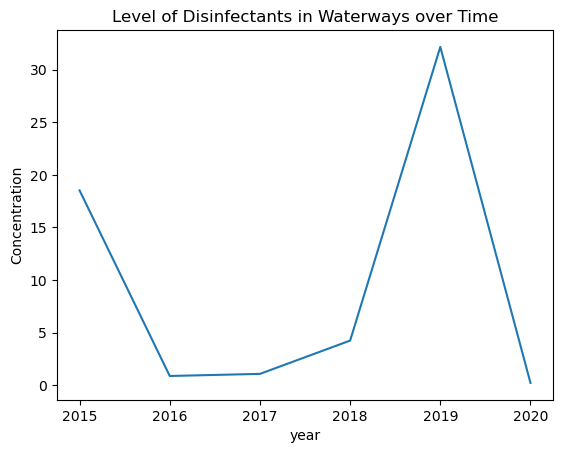

In [11]:
#list of types of waterways
unique_locations = LCMS_GCMS_df['SMC_DESC'].unique()
#print(unique_locations)

#concat groundwater types in one column
groundwater = "GROUNDWATER"
water_type_list = LCMS_GCMS_df['SMC_DESC'].tolist()
new_water_list = []

for water in water_type_list:
    if re.search(groundwater,water):
        new_water_list.append("GROUNDWATER")
    else:
        new_water_list.append(water)

LCMS_GCMS_df['Water Type Simplified'] = new_water_list

#plot chemical levels over time
def plot_years(chemical_type, g_title):
    year_df = pd.DataFrame(LCMS_GCMS_df.loc[(LCMS_GCMS_df["Usages"] == chemical_type) & (LCMS_GCMS_df['year'] > 2014) & 
                                       (LCMS_GCMS_df['year'] < 2021)]) 
    unique_chemical_timeline = year_df.groupby('year')['Concentration'].mean()
    sns.lineplot(data=unique_chemical_timeline, x='year', y=unique_chemical_timeline).set(title=g_title)
    
#plot_years("Pesticide or Insecticide", "Level of Pesticides in Waterways over Time")
#plot_years("Addictive Drug", "Level of Addictive Drugs in Waterways over Time")
#plot_years("Prescription Drug", "Level of Prescription Drugs in Waterways over Time")
#plot_years("Plasticizer", "Level of Plasticizers in Waterways over Time")
plot_years("Disinfectant", "Level of Disinfectants in Waterways over Time")
#plot_years("Polymer", "Level of Polymers in Waterways over Time")
#plot_years("Corrison Inhibiter; Drug Precusor ", "Level of Corrison Inhibitors in Waterways over Time")
#plot_years("Personal Care Products", "Level of Personal Care Products in Waterways over Time")

#print(LCMS_df["Year"].unique())

['Anticonvulsant' 'Antihistamine' 'HIV protease inhibitor'
 'Antihyperlipemic' 'Benzodiazepine; Anti-Anxiety drug'
 'Opiate used to treat pain' 'Sedative; Hypnotic'
 'Anesthetic; Antiarrhythmic' 'Sedatine; Hypnotic'
 'Antibiotic; Antiprotozoal medication' 'Sedative drug'
 'Anticholesteremic' 'Antiandrogen medication'
 'Preservative; Antiseptic; Disinfectant' 'H2-Blocker' 'Antibiotic'
 'Antiplatelet agent ' 'Antineoplastic'
 'Nonsteroidal anti-inflammatory drug' 'Antiseptic' 'Antidiabetic'
 'Antiulcerative; Anti-infective' 'Prostaglandin analogue'
 'Dye; Antimicrobial' 'Gyrase inhibitor' 'Hormone; Sedative'
 'Antihypertensive' 'Analgesic'
 'Antibiotic; Therapeutic Agent; Natural Product' 'Analgesic; Antipyretic'
 'Antiparkinsonian' 'Pharmaceutical aid; Artificial Sweetener'
 'Cholesterol synthesis inhibitor' 'Anti-Inflammatory drug'
 'Antihypertonic' 'Antiseptic; Bactericide; Disinfectant' 'Anesthetic'
 'Mild Sedative' 'Intermediate; Pharmaceuticals; Agrochemicals; Dyes'
 'Antiseptic; P

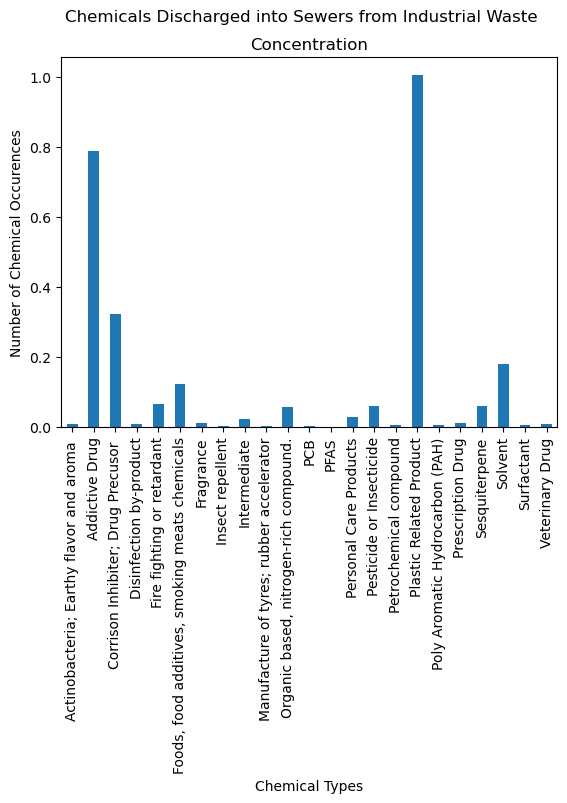

In [12]:
#lists of unique chemicals and unique prescription drugs
unique_chemical_groundwater = LCMS_GCMS_df['Usages'].unique().tolist()
prescription_drug_list = LCMS_GCMS_df.loc[LCMS_GCMS_df['Usages'] == 'Prescription Drug', 'USE']
print(prescription_drug_list.unique())

#function to make graphs based on different waterway types
def plot_waterway_graphs(waterway_type, g_title, sample_list, x_label):
    groundwater_df = LCMS_GCMS_df.loc[(LCMS_GCMS_df["SMC_DESC"] == waterway_type) & (LCMS_GCMS_df["year"] > 2019)]
    unique_chemical_list = groundwater_df.groupby(sample_list)['Concentration'].mean()
    unique_chemical_list.plot(xlabel=x_label, ylabel='Number of Chemical Occurences', 
                             title=g_title, kind='bar',subplots=True)

#plot_waterway_graphs("GROUNDWATER", "Chemicals in Groundwater", 'Usages', 
                    #'Chemical Types')
#plot_waterway_graphs("RIVER / RUNNING SURFACE WATER", "Chemicals in Rivers or other Running Surface Waters", 'Usages', 
                     #'Chemical Types')
#plot_waterway_graphs("ESTUARINE WATER", "Chemicals in Estuarine Water", 'Usages', 
                    #'Chemical Types')
#plot_waterway_graphs("SEA WATER", "Chemicals in Seawater", 'Usages', 
                     #'Chemical Types')
#plot_waterway_graphs("POND / LAKE / RESERVOIR WATER", "Chemicals in Ponds, Lakes, or Reservoirs", 'Usages', 
                     #'Chemical Types')
plot_waterway_graphs("ANY TRADE EFFLUENT", "Chemicals Discharged into Sewers from Industrial Waste", 'Usages', 
                     'Chemical Types')


In [13]:
#get graphs of unique prescription drugs
#plot_waterway_graphs("POND / LAKE / RESERVOIR WATER", "Chemicals in Ponds, Lakes, or Reservoirs", 
                    # prescription_drug_list,'Prescription Drug Type')
#plot_waterway_graphs("GROUNDWATER", "Chemicals in Groundwater", 
                     #prescription_drug_list, 'Prescription Drug Type')
#plot_waterway_graphs("RIVER / RUNNING SURFACE WATER", "Chemicals in Rivers or Other Running Surface Waters", 
                     #prescription_drug_list, 'Prescription Drug Type')
#plot_waterway_graphs("ESTUARINE WATER", "Chemicals in Estuarine Water", 
                     #prescription_drug_list, 'Prescription Drug Type')
plot_waterway_graphs("SEA WATER", "Chemicals in Seawater", prescription_drug_list, 'Prescription Drug Type')
#plot_waterway_graphs("ANY TRADE EFFLUENT", "Chemicals Discharged into Sewers from Industrial Waste", prescription_drug_list, 
                    #'Prescription Drug Type')


#update graphs
#map of UK
#multiple linear regression for ecotox data


/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_99379/4286182458.py:9: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  unique_chemical_list = groundwater_df.groupby(sample_list)['Concentration'].mean()


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
#LCMS_df.to_csv('LCMS.csv')

In [ ]:
#pesticides and insecticides list
#endocrine disruptors list
#plasticizers list
#solvents list
#Addictive drugs list
#personal care products list

#highest pesticide concentration graph
pesticide_df = LCMS_GCMS_df.loc[LCMS_GCMS_df["Usages"] == 'Pesticide or Insecticide']
high_pesticides = pesticide_df.loc[pesticide_df["Concentration"] >= 20000]
pesticide_df['Compound_Name'].unique()

sns.barplot(x='Compound_Name', y='Concentration', data=high_pesticides)

#highest endocrine disruptor graph
endocrine_df = LCMS_GCMS_df.loc[LCMS_GCMS_df["USE"]=='Endocrine disruptor']
endocrine_df.head()

sns.barplot(x='Compound_Name', y='Concentration', data=endocrine_df)

#highest anesthetic graph
anesthetic_df = LCMS_GCMS_df.loc[(LCMS_GCMS_df["USE"] == 'Anesthetic') | (LCMS_GCMS_df["USE"] == 'Anesthetic; Antiarrhythmic')]
sns.barplot(x='Compound_Name', y='Concentration', data=anesthetic_df)

#highest sedative graph
sedative_df = LCMS_GCMS_df.loc[LCMS_GCMS_df["USE"] == 'Mild Sedative']
sns.barplot(x='Compound_Name', y='Concentration', data=sedative_df)

#highest addictive drug graph
addictive_df = LCMS_GCMS_df.loc[LCMS_GCMS_df["Usages"] == "Addictive Drug"]
sns.barplot(x='Compound_Name', y="Concentration", data=addictive_df)

#highest prescription drug graph
script_df = LCMS_GCMS_df.loc[(LCMS_GCMS_df["Usages"] == "Prescription Drug") & (LCMS_GCMS_df["Concentration"] > 100)]
sns.barplot(x='Compound_Name', y="Concentration", data=script_df)

#highest plasticizers
plasticizer_df = LCMS_GCMS_df.loc[(LCMS_GCMS_df["Usages"] == "Plasticizer") & (LCMS_GCMS_df["Concentration"] > 100)]
sns.barplot(x='Compound_Name', y="Concentration", data=plasticizer_df)

#highest polymers
polymer_df = LCMS_GCMS_df.loc[LCMS_GCMS_df["Usages"] == "Polymer"]
sns.barplot(x='Compound_Name', y="Concentration", data=polymer_df)
plt.xticks(rotation=90)

#highest corrison inhibitors
#corrison_df = LCMS_df.loc[LCMS_df["Usages"] == "Corrison Inhibiter; Drug Precusor "]
#sns.barplot(x='Compound_Name', y="Concentration", data=corrison_df)


['NORTH EAST - YORKSHIRE' 'MIDLANDS - SHROPS HEREF WORCS AND GLOS'
 'ANGLIAN - LINCS AND NORTHANTS' 'ANGLIAN - ESSEX NORFOLK AND SUFFOLK'
 'SOUTHERN - SOLENT AND SOUTH DOWNS' 'MIDLANDS - DERBYS NOTTS AND LEICS'
 'NORTH WEST - CUMBRIA AND LANCASHIRE' 'ANGLIAN - CAMBS AND BEDFORDSHIRE'
 'SOUTHERN - KENT AND SOUTH LONDON' 'THAMES - KENT AND SOUTH LONDON'
 'NORTH EAST - NORTHUMBERLAND DURHAM AND TEES'
 'THAMES - HERTS AND NORTH LONDON' 'MIDLANDS - STAFFS WARKS AND WEST MIDS'
 'THAMES - WEST THAMES' 'NORTH WEST - GTR MANCS MERSEY AND CHES'
 'SOUTH WEST - WESSEX' 'SOUTH WEST - DEVON AND CORNWALL' 'Regional']
18


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Intermediate'),
  Text(1, 0, 'Plastic Related Product'),
  Text(2, 0, 'Prescription Drug'),
  Text(3, 0, 'Addictive Drug'),
  Text(4, 0, 'Solvent'),
  Text(5, 0, 'Pesticide or Insecticide'),
  Text(6, 0, 'Fire fighting or retardant')])

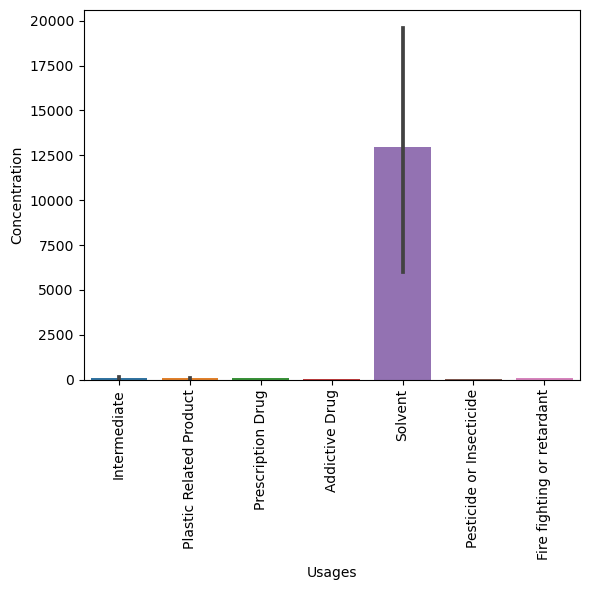

In [14]:
geo_list = LCMS_GCMS_df['ARE_DESC']
print(LCMS_GCMS_df['ARE_DESC'].unique())
print(len(LCMS_GCMS_df['ARE_DESC'].unique()))

LCMS_northeast = LCMS_GCMS_df.loc[(LCMS_GCMS_df['ARE_DESC']=='NORTH EAST - NORTHUMBERLAND DURHAM AND TEES') & 
                             (LCMS_GCMS_df['Concentration'] > 50)]
LCMS_northeast.head()

sns.barplot(x='Usages', y='Concentration', data=LCMS_northeast)
plt.xticks(rotation=90)

In [15]:
unique_compounds_list = LCMS_GCMS_df['Compound_Name'].unique()
print(unique_compounds_list)
print(len(unique_compounds_list))

['2,4-DB / 2,4-Dichlorophenoxybutyric acid' '2,6-Dichlorobenzamide'
 '2-Ethylhexldiphenyl phosphate' ... 'UV-328' 'Vanillin' 'Xylenes (total)']
1016


In [16]:
#read a book about chemistry
#create flode chart - transforming and scaling data
#organize compounds by their chemical structure
#research and organize by effect

#cluster by how many samples have been taken

#impute NAN values

#discover effects in ecotox database by CAS

      

In [17]:
print(len(LCMS_GCMS_df['SMC_DESC'].isnull()))
print(len(LCMS_GCMS_df))

649217
649217


In [18]:
#LCMS_df.to_csv('LCMS.csv')

In [19]:
#subset for just pesticide data
pesticides_df = LCMS_GCMS_df.loc[LCMS_GCMS_df['Usages']=='Pesticide or Insecticide']
#print(pesticides_df['ARE_DESC'].unique())
pesticides_df = pesticides_df.loc[(pesticides_df['ARE_DESC']=='ANGLIAN - ESSEX NORFOLK AND SUFFOLK')]
unique_pesticides_compounds = pesticides_df['Compound_Name'].unique()
print(unique_pesticides_compounds)
print(len(unique_pesticides_compounds))
print(len(unique_pesticides_compounds))
pesticides_df.head()

['2,6-Dichlorobenzamide' '2-Phenoxypropionic acid'
 '4-Chlorophenoxyacetic acid / CPA / 4-CPA ' 'Acetamiprid' 'Acetazolamide'
 'Amidosulfuron' 'Asulam' 'Atrazine'
 'Atrazine-desethyl (Desethylatrazine)' 'Atrazine-desethyl-desisopropyl'
 'Atrazine-desisopropyl (Deisopropylatrazine)' 'Azoxystrobin' 'Bentazone'
 'Benzimidazole' 'Boscalid (Nicobifen)' 'Bromacil' 'Bromoxynil'
 'Buprofezin' 'Carbetamide' 'Carboxin' 'Chlorfenvinphos' 'Chlorpyrifos'
 'Chlortoluron (Chlorotoluron)' 'Clomazone' 'Clopyralid' 'Clothianidin'
 'Cycluron' 'Cyproconazole' 'Cyprodinil' 'Cyromazine'
 'Diazinon (Dimpylate)' 'Dichlorprop' 'Difenconazole' 'Dimefox'
 'Dimethenamid (SAN 582H)' 'Dimethoate' 'Dimethomorph' 'Dimoxystrobin'
 'Dinoseb' 'Dioxacarb' 'Diuron' 'Epoxiconazole (BAS 480F)' 'Etaconazole'
 'Ethofumesate' 'Ethoprop (Ethoprophos)' 'Famoxadone' 'Fenhexamid'
 'Fenpropimorph (Ro 14-3169)' 'Fenuron (N,N-Dimethyl-N-phenylurea)'
 'Fipronil' 'Flamprop-isopropyl' 'Flonicamid' 'Fluazinam (Shirlan)'
 'Fludioxonil' 'F

,Sample_Site_ID,MEAS_DETERMINAND_CODE,SAMP_ID,Screening_Method_Details_Code,SAMP_MATERIAL,SMC_DESC,SAMP_PURPOSE_CODE,PURP_DESC,Sample_datetime,SMPT_LONG_NAME,...,less_than,CAS_Number,Compound_Name,LOD,USE,method,year,month_and_year,Usages,Water Type Simplified
5,WAV120,7299,1943318,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MS,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,2019-09-02 13:00:00,R.WAVENEY ELLINGHAM MILL,...,False,2008584,"2,6-Dichlorobenzamide",0.001,Pesticide; Dichlobenil metabolite,LCMS,2019,Sep 2019,Pesticide or Insecticide,RIVER / RUNNING SURFACE WATER
15,WAV120,7299,1946617,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MS,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,2019-10-15 07:50:00,R.WAVENEY ELLINGHAM MILL,...,False,2008584,"2,6-Dichlorobenzamide",0.001,Pesticide; Dichlobenil metabolite,LCMS,2019,Oct 2019,Pesticide or Insecticide,RIVER / RUNNING SURFACE WATER
17,WEN250,7299,1894492,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MU,MONITORING (UK GOVT POLICY - NOT GQA OR RE),2018-02-16 14:29:00,R.WENSUM SWEET BRIAR RD.BR.,...,False,2008584,"2,6-Dichlorobenzamide",0.001,Pesticide; Dichlobenil metabolite,LCMS,2018,Feb 2018,Pesticide or Insecticide,RIVER / RUNNING SURFACE WATER
18,WAV120,7299,1943225,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MU,MONITORING (UK GOVT POLICY - NOT GQA OR RE),2019-08-30 08:05:00,R.WAVENEY ELLINGHAM MILL,...,False,2008584,"2,6-Dichlorobenzamide",0.001,Pesticide; Dichlobenil metabolite,LCMS,2019,Aug 2019,Pesticide or Insecticide,RIVER / RUNNING SURFACE WATER
20,PINMILL2,7299,1915114,TS1,2EZZ,GROUNDWATER,MS,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,2018-10-10 14:47:00,"LONG WOOD SPRING, PINMILL, CHELMONDISTON",...,False,2008584,"2,6-Dichlorobenzamide",0.001,Pesticide; Dichlobenil metabolite,LCMS,2018,Oct 2018,Pesticide or Insecticide,GROUNDWATER


In [20]:
pesticides_df.isnull().values.any()
pesticides_df.isnull().sum().sum()
print(len(pesticides_df))

44495


In [21]:
null_conc = pesticides_df[pesticides_df['Concentration'].isnull()]
pesticides_df.dropna(subset=['Concentration'], inplace = True)
pesticides_df.head()

,Sample_Site_ID,MEAS_DETERMINAND_CODE,SAMP_ID,Screening_Method_Details_Code,SAMP_MATERIAL,SMC_DESC,SAMP_PURPOSE_CODE,PURP_DESC,Sample_datetime,SMPT_LONG_NAME,...,less_than,CAS_Number,Compound_Name,LOD,USE,method,year,month_and_year,Usages,Water Type Simplified
5,WAV120,7299,1943318,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MS,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,2019-09-02 13:00:00,R.WAVENEY ELLINGHAM MILL,...,False,2008584,"2,6-Dichlorobenzamide",0.001,Pesticide; Dichlobenil metabolite,LCMS,2019,Sep 2019,Pesticide or Insecticide,RIVER / RUNNING SURFACE WATER
15,WAV120,7299,1946617,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MS,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,2019-10-15 07:50:00,R.WAVENEY ELLINGHAM MILL,...,False,2008584,"2,6-Dichlorobenzamide",0.001,Pesticide; Dichlobenil metabolite,LCMS,2019,Oct 2019,Pesticide or Insecticide,RIVER / RUNNING SURFACE WATER
17,WEN250,7299,1894492,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MU,MONITORING (UK GOVT POLICY - NOT GQA OR RE),2018-02-16 14:29:00,R.WENSUM SWEET BRIAR RD.BR.,...,False,2008584,"2,6-Dichlorobenzamide",0.001,Pesticide; Dichlobenil metabolite,LCMS,2018,Feb 2018,Pesticide or Insecticide,RIVER / RUNNING SURFACE WATER
18,WAV120,7299,1943225,TS1,2AZZ,RIVER / RUNNING SURFACE WATER,MU,MONITORING (UK GOVT POLICY - NOT GQA OR RE),2019-08-30 08:05:00,R.WAVENEY ELLINGHAM MILL,...,False,2008584,"2,6-Dichlorobenzamide",0.001,Pesticide; Dichlobenil metabolite,LCMS,2019,Aug 2019,Pesticide or Insecticide,RIVER / RUNNING SURFACE WATER
20,PINMILL2,7299,1915114,TS1,2EZZ,GROUNDWATER,MS,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...,2018-10-10 14:47:00,"LONG WOOD SPRING, PINMILL, CHELMONDISTON",...,False,2008584,"2,6-Dichlorobenzamide",0.001,Pesticide; Dichlobenil metabolite,LCMS,2018,Oct 2018,Pesticide or Insecticide,GROUNDWATER


In [22]:
print(pesticides_df['CAS_Number'].unique())

[   2008584     940318     122883  135410207      59665  120923377
    3337711    1912249    6190654    3397624    1007289  131860338
   25057890      51172  188425856     314409    1689845   69327760
   16118493    5234684     470906    2921882   15545489   81777891
    1702176  210880925    2163691  113096994  121552612   66215278
     333415     120365  119446683     115264   87674688      60515
  110488705  149961524      88857    6988212     330541  135319732
   71245233   26225796   13194484  131807573  126833178   67564914
     101428  120068373   52756226   79622596  131341861  142459583
  239110157  361377299  136426545   96525234   85509199   66332965
   76674210   98886443   65907304     126078   35554440  138261413
      94757    2164081     330552      94746      94815    7085190
   57837191   41394052   67129082   18691979    2032657    3060897
   51218452   21087649    1746812     150685   88671890   15299997
  116255482   10605217  500008457    1698608    6339191   1725

In [23]:
#ask Li about LOD - is less than less than LOD

#linear regression for prediction of concentration by year
#linear regresssion for prediction of effect 
#negative effect classification using one vs all ML methods

In [24]:
#print(pesticides_df['Compound_Name'].unique())
#print(pesticides_df.loc[pesticides_df['CAS_Number']==80387])
responses_df.head()

,dose_resp_id,test_id,sample_size_unit,sample_size_comments,effect_code,measurement_code,measurement_comments,response_site,response_site_comments,obs_duration_mean_op,obs_duration_mean,obs_duration_min_op,obs_duration_min,obs_duration_max_op,obs_duration_max,obs_duration_unit,obs_duration_comments,response_unit,response_comments,additional_comments
0,1,1,ML,NaN,ENZ,ATRP,NaN,PL,NaN,NaN,15,NaN,NR,NaN,NR,d,NaN,IU/L,NaN,NaN
1,2,1,ML,NaN,ENZ,GGTR,NaN,PL,NaN,NaN,15,NaN,NR,NaN,NR,d,NaN,IU/L,NaN,NaN
2,3,1,ML,NaN,HRM,TSTR,NaN,PL,NaN,NaN,15,NaN,NR,NaN,NR,d,NaN,ng/ml,NaN,NaN
3,4,2,ML,NaN,ENZ,BCOD,NaN,LI,NaN,NaN,4,NaN,NR,NaN,NR,d,NaN,umol/mg/mi,NaN,NaN
4,5,2,ML,NaN,ENZ,BROD,NaN,LI,NaN,NaN,4,NaN,NR,NaN,NR,d,NaN,pmol/mg/mi,NaN,NaN


In [25]:
tests_subset = tests_df[['test_id','test_cas']]
tests_subset = tests_subset.dropna(subset=['test_id'])
responses_subset = responses_df[['test_id','effect_code','response_unit']]
responses_subset = responses_subset.dropna(subset=['test_id'])
chemicals_df['test_cas']=chemicals_df['cas_number']
chemicals_subset = chemicals_df[['test_cas','chemical_name','ecotox_group']]
chemicals_subset = chemicals_subset.dropna(subset=['test_cas'])
doses_subset = doses_df[['test_id','dose_number','dose_conc_unit']]


In [26]:
test_responses = pd.merge(tests_subset,responses_subset,on='test_id',how='left')
test_responses = pd.merge(test_responses,chemicals_subset,on='test_cas',how='left')
test_responses = pd.merge(test_responses,doses_subset,on='test_id',how='left')

test_responses['code'] = test_responses['effect_code']
#test_responses = test_responses.drop(['effect_code'])
test_responses = pd.merge(test_responses,effect_codes_df,on='code',how='left')

test_responses.head()

#endpoint codes, measurement codes

,test_id,test_cas,effect_code,response_unit,chemical_name,ecotox_group,dose_number,dose_conc_unit,code,description
0,1,1336363,ENZ,IU/L,"1,1'-Biphenyl, Chloro derivs.",Polychlorinated Biphenyls (PCBs)Endocrine Disr...,1.0,mg/kg,ENZ,Enzyme(s)
1,1,1336363,ENZ,IU/L,"1,1'-Biphenyl, Chloro derivs.",Polychlorinated Biphenyls (PCBs)Endocrine Disr...,2.0,mg/kg,ENZ,Enzyme(s)
2,1,1336363,ENZ,IU/L,"1,1'-Biphenyl, Chloro derivs.",Polychlorinated Biphenyls (PCBs)Endocrine Disr...,3.0,mg/kg,ENZ,Enzyme(s)
3,1,1336363,ENZ,IU/L,"1,1'-Biphenyl, Chloro derivs.",Polychlorinated Biphenyls (PCBs)Endocrine Disr...,4.0,mg/kg,ENZ,Enzyme(s)
4,1,1336363,ENZ,IU/L,"1,1'-Biphenyl, Chloro derivs.",Polychlorinated Biphenyls (PCBs)Endocrine Disr...,1.0,mg/kg,ENZ,Enzyme(s)


In [27]:
#drop nan cas at end of dataframe in test_responses
test_responses = test_responses.dropna(subset=['test_cas'])
test_responses[test_responses['effect_code'].isna()]

,test_id,test_cas,effect_code,response_unit,chemical_name,ecotox_group,dose_number,dose_conc_unit,code,description
124,15,56382,NaN,NaN,"Phosphorothioic acid, O,O-Diethyl-O-(4-nitroph...",NaN,NaN,NaN,NaN,NaN
125,16,63252,NaN,NaN,1-Naphthalenol methylcarbamate,Endocrine Disrupting Chemicals (EDCs),NaN,NaN,NaN,NaN
126,17,50293,NaN,NaN,"1,1'-(2,2,2-Trichloroethylidene)bis[4-chlorobe...",DDT and metabolites,NaN,NaN,NaN,NaN
159,22,709988,NaN,NaN,"N-(3,4-Dichlorophenyl)propanamide",NaN,1.0,g/kg,NaN,NaN
160,22,709988,NaN,NaN,"N-(3,4-Dichlorophenyl)propanamide",NaN,2.0,g/kg,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1435929,2303878,7758987,NaN,NaN,Sulfuric acid copper(2+) salt (1:1),Copper,4.0,mg/L,NaN,NaN
1435930,2303878,7758987,NaN,NaN,Sulfuric acid copper(2+) salt (1:1),Copper,5.0,mg/L,NaN,NaN
1435931,2303878,7758987,NaN,NaN,Sulfuric acid copper(2+) salt (1:1),Copper,6.0,mg/L,NaN,NaN
1435932,2303878,7758987,NaN,NaN,Sulfuric acid copper(2+) salt (1:1),Copper,1.0,mg/L,NaN,NaN


In [28]:
pesticides_df = pesticides_df[['SMC_DESC','SMPT_LONG_NAME','CAS_Number','Compound_Name','Concentration','Usages','ARE_DESC']]
pesticides_df['test_cas'] = pesticides_df['CAS_Number']
pesticides_df.head()

,SMC_DESC,SMPT_LONG_NAME,CAS_Number,Compound_Name,Concentration,Usages,ARE_DESC,test_cas
5,RIVER / RUNNING SURFACE WATER,R.WAVENEY ELLINGHAM MILL,2008584,"2,6-Dichlorobenzamide",0.0023,Pesticide or Insecticide,ANGLIAN - ESSEX NORFOLK AND SUFFOLK,2008584
15,RIVER / RUNNING SURFACE WATER,R.WAVENEY ELLINGHAM MILL,2008584,"2,6-Dichlorobenzamide",0.0045,Pesticide or Insecticide,ANGLIAN - ESSEX NORFOLK AND SUFFOLK,2008584
17,RIVER / RUNNING SURFACE WATER,R.WENSUM SWEET BRIAR RD.BR.,2008584,"2,6-Dichlorobenzamide",0.0200,Pesticide or Insecticide,ANGLIAN - ESSEX NORFOLK AND SUFFOLK,2008584
18,RIVER / RUNNING SURFACE WATER,R.WAVENEY ELLINGHAM MILL,2008584,"2,6-Dichlorobenzamide",0.0024,Pesticide or Insecticide,ANGLIAN - ESSEX NORFOLK AND SUFFOLK,2008584
20,GROUNDWATER,"LONG WOOD SPRING, PINMILL, CHELMONDISTON",2008584,"2,6-Dichlorobenzamide",0.5700,Pesticide or Insecticide,ANGLIAN - ESSEX NORFOLK AND SUFFOLK,2008584


In [ ]:
ecotox_LCMS_df = pd.merge(test_responses,pesticides_df,on='test_cas',how='left')
ecotox_LCMS_df.head()

In [ ]:
ecotox_LCMS_df.dropna(subset=['Compound_Name'], inplace=True)
#ecotox_LCMS_df = ecotox_LCMS_df.drop(columns=['CAS_Number'])
ecotox_LCMS_df.info()

In [ ]:
ecotox_LCMS_df = ecotox_LCMS_df.reset_index()

In [ ]:
ecotox_LCMS_df[ecotox_LCMS_df['ecotox_group'].isna()]
ecotox_LCMS_df.info()
print(len(ecotox_LCMS_df))
ecotox_LCMS_df.tail()

In [ ]:
print(max(ecotox_LCMS_df['test_id']))

In [ ]:
ecotox_LCMS_df = ecotox_LCMS_df.drop_duplicates(subset=['test_id'])

#print(ecotox_LCMS_df.isnull())
#get list of chemicals which have null effects
#graphs for non null chemicals
print(len(ecotox_LCMS_df['Compound_Name'].unique()))
#list of chemicals which have null effects
null_effect_list = ecotox_LCMS_df.loc[ecotox_LCMS_df['effect_code'].isna()]
print(len(null_effect_list['Compound_Name'].unique()))


In [ ]:
#ecotox_LCMS_df.info()
#ecotox_LCMS_df.to_csv('ecotox_LCMS_3.csv')
#print(len(ecotox_LCMS_df))

ecotox_LCMS_df_filtered = ecotox_LCMS_df.loc[(ecotox_LCMS_df['test_id'].notnull()) & ecotox_LCMS_df['effect_code'].notnull()]
ecotox_LCMS_df_null = ecotox_LCMS_df.loc[(ecotox_LCMS_df['effect_code'].isna())]
ecotox_LCMS_df_null.head()

In [ ]:
#find list of chemicals with effects
chemicals_with_effects = ecotox_LCMS_df_filtered['Compound_Name'].unique()
#print('chemicals which have been studied: ',chemicals_with_effects)
chemicals_without_effects = ecotox_LCMS_df_null['Compound_Name'].unique()
#print('chemicals which have not been studied: ',chemicals_without_effects)
unique_chemical_list = LCMS_GCMS_df['Compound_Name'].unique()

#get list of chemicals without studied effects
#do research on these specific chemicals
#find some papers to confirm results of chemical effects, particularly endocrine disruptors
#read about basic chemistry in order to predict based on chemical name
#see chemicals which don't have many studied effects
#assign readings for these chemicals

#ecotox_LCMS_df_filtered.to_csv('only_effects.csv')
for chemical in unique_chemical_list:
    print(chemical)

In [ ]:
#for chemical in LCMS_GCMS_df_unique_chemicals_list:
#if chemical NOT in LCMS_GMCS_filtered
#append to new list
#print list




In [ ]:
#simulate endpoint using markov chain
#get mean of endpoint codes for each pesticide

#use it to calcualte probability of moving from this level of pesticide to this state - death, problems with reproduction, 
#endocrine problems, mass extinctions etc.
#model fish populations over time
#level of pesticides in future using time series modeling 
#find probability of each state for each pesticide

#predict responses based on chemical name - IU PAC
#group by organic and inorganic - carbon and non carbonic

In [ ]:
#exploratory data analysis
#put notes
#find 4 papers and read

#supervised learning on dataset to answer hypotheses
#
#what do we predict will be the level of pesticides in the future based on the past - do specific pesticides, talk to group
#validation of fatality effects by looking at fish population level over time ***********
#crossing the limit effects - fatal threshold - minimum inhibitory concentration - for fatality
#What can we do to reduce harmful effects of pesticides
#compare which chemicals are more likely to cause mortality